# Learning geometry of geodesics

This is the work done with Samuel Gruffaz on using RKHS to learn the shape of the geodesics.

In [1]:
import numpy as np
import pandas as pd
import torch
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


import sys, os


os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

from leaspy.api import Leaspy

from leaspy import Leaspy, Data, AlgorithmSettings, Plotter, Dataset, IndividualParameters
from leaspy.models.utils.attributes.attributes_factory import AttributesFactory
from leaspy.algo.algo_factory import AlgoFactory
#from leaspy.utils.visualisation.visual_update_b import *




In [2]:
def generate_data(model, n_individuals, nb_visits_min, nb_visits_mean, window):
    # Sampling individuals :

    N = n_individuals

    individuals = []

    data = [[], []] + [[] for k in range(model.dimension)]

    for i in range(N):
        tau = np.random.normal(loc=model.parameters['tau_mean'], scale=model.parameters['tau_std'])
        xi = np.random.normal(loc=model.parameters['xi_mean'], scale=model.parameters['xi_std'])
        n_tpts = nb_visits_min + np.random.binomial(2 * (nb_visits_mean-nb_visits_min),0.5)
        tpts = np.sort((np.random.normal(0., 1., size=(n_tpts)) * window) + tau)
        timepoints = torch.tensor(tpts, dtype=float)
        sources = None
        if model.source_dimension is not None:
            sources = np.random.normal(loc=model.parameters['sources_mean'], scale=model.parameters['sources_std'], size=(model.source_dimension))
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi), "sources":torch.Tensor(sources)}).detach().numpy()
        else:   
            values = model.compute_individual_tensorized(timepoints, {"tau":torch.tensor(tau), "xi":torch.tensor(xi)}).detach().numpy()
        values = values + np.random.normal(0., model.parameters['noise_std'], size=(n_tpts, model.dimension))
        individuals.append({"idx":i+1, "tau":tau, "xi":xi, "tpts":tpts, "sources":sources, "values":values})
        data[0] += [i+1] * n_tpts
        data[1] += list(tpts)
        for k in range(model.dimension):
            data[2+k] += list(values[0, :, k])
    data = np.array(data).T
    df = pd.DataFrame(data, columns=['ID', 'TIME']+["Y"+str(k+1) for k in range(model.dimension)])
    df.set_index(['ID', 'TIME'], inplace=True)
    return df, individuals

def plot_generative(ax, individuals, model1, nb_ind_plot, dimension):

    for i in range(nb_ind_plot):
        params = individuals[i]
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model1.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(individuals[i]['tpts'], individuals[i]['values'][0,:,j], "o")
            ax[i,j].plot(t, trajectory[..., j])

def plot_points(ax, dataset, nb_ind_plot, dimension):
    tps=dataset.timepoints
    Y=dataset.values
    mask=dataset.mask
    for i in range(nb_ind_plot):
        ind=mask[i].bool().all(axis=1)
        
        Z=Y[i,ind]
        tpsi=tps[i,ind]
       
      
        for j in range(dimension):
            ax[i,j].plot(tpsi, Z[:,j], "o")
            

def plot_fit(ax, results, model, dataset,nb_ind_plot, dimension):
    tps=dataset.timepoints
    
    for i in range(nb_ind_plot):
        tpts=tps[i,:dataset.nb_observations_per_individuals[i]].numpy()
        
        params = results._individual_parameters[results._indices[i]]
        params["tpts"]=tpts
        mean_par = {key:torch.tensor(params[key])for key in ["tau", "xi"]}
        mean_par["sources"] = torch.Tensor(params["sources"])
        t = torch.tensor(np.linspace(np.min(params["tpts"])-1.,np.max(params["tpts"])+1.,100), dtype=torch.float)

        trajectory = model.compute_individual_tensorized(t, mean_par).squeeze(0)
        for j in range(dimension):
            ax[i,j].plot(t, trajectory[..., j])

In [ ]:



def plot_average_update(model,ax,modelref=None,name=None):
    """
    Parameters: model, linear_b model already calibrated with update_b
        ax, (dimension) subplots

    """
    timepoints = np.linspace(60, 80, 100)
    if modelref is not None:
        number_of_sources = modelref.model.random_variable_informations()["sources"]["shape"][0]
        mean_xiref = modelref.model.parameters['xi_mean'].numpy()
        mean_tauref = modelref.model.parameters['tau_mean'].numpy()
        mean_sourceref = modelref.model.parameters['sources_mean'].numpy().tolist()
        mean_sourcesref = [mean_sourceref]*number_of_sources
        
        model.model.source_dimension=1
        
        average_parametersref = {'xi': mean_xiref,'tau': mean_tauref,'sources': mean_sourcesref}
        ip_averageref = IndividualParameters()
        ip_averageref.add_individual_parameters('average', average_parametersref)
        valuesref = model.estimate({'average': timepoints}, ip_averageref)
        for i in range(model.model.dimension):
            ax[i].plot(timepoints, valuesref['average'].T[i], linewidth=3,label="reference",c="red")


    # —— Get the average individual parameters
    d=model.model.dimension
    
    Lparam=model.model.saveParam
    LB=model.model.saveB.copy()
    print(len(LB))
    cm = plt.get_cmap('winter')

    for i in range(d):
        
        number_of_sources = model.model.random_variable_informations()["sources"]["shape"][0]
        
        for j in range(len(LB)):
            if i==0:
                print("norme W")
                print(torch.norm(torch.tensor(LB[j][0]),dim=0))
            
            if type(Lparam[j]['xi_mean']) is torch.Tensor:
                mean_xi = Lparam[j]['xi_mean'].numpy()
                mean_tau = Lparam[j]['tau_mean'].numpy()
                mean_source = Lparam[j]['sources_mean'].numpy().tolist()
            else:
                mean_xi = Lparam[j]['xi_mean']
                mean_tau = Lparam[j]['tau_mean']
                mean_source = Lparam[j]['sources_mean']
            mean_sources = [mean_source]*number_of_sources
            model.model.saveB=LB[:j]
            model.model.reconstructionB()

# —— Store the average individual parameters in a dedicated object
            average_parameters = {'xi': mean_xi,'tau': mean_tau,'sources': mean_sources}
            ip_average = IndividualParameters()
            ip_average.add_individual_parameters('average', average_parameters)
            values = model.estimate({'average': timepoints}, ip_average)
            
            if j==0:
                ax[i].plot(timepoints, values['average'].T[i], linewidth=1,label="init ",c=cm(1.*j/(len(LB)-1)))
            else:
                ax[i].plot(timepoints, values['average'].T[i], linewidth=1,label="comp "+str(j),c=cm(1.*j/(len(LB)-1)))
        ax[i].set_xlabel("time")
        ax[i].set_ylabel("dim"+str(i))
        
    model.model.saveB=LB



def plot_variability(model, tps,nb_vari,fen):
    params={}
    

    nb_s=model.model.source_dimension
    print(nb_s)
    dimension=model.model.dimension
    fig1, ax1 = plt.subplots(dimension, nb_s, figsize=(4*dimension,16*nb_s))
    for i in range(nb_s):
        SS=torch.zeros(nb_vari,nb_s)
        SS[:,i]=torch.linspace(-fen,fen,nb_vari)
        
        t = tps

        
        for j in range(dimension):
            for k in range(nb_vari):
        
                mean_par={"tau":model.model.parameters["tau_mean"],"xi":model.model.parameters["xi_mean"]}
                mean_par["sources"] = SS[k]
                trajectory = model.model.compute_individual_tensorized(t, mean_par).squeeze(0)
                
                if len(ax1.shape)>1:
                    ax1[j,i].plot(t, trajectory[..., j],label="source "+str(i)+": {:.2f}".format(SS[k,i]))
                    ax1[j,i].set_xlabel("time")
                    ax1[j,i].set_ylabel("dim"+str(j))
                else:
                    ax1[j].plot(t, trajectory[..., j],label="source "+str(i)+": {:.2f}".format(SS[k,i]))
                    ax1[j].set_xlabel("time")
                    ax1[j].set_ylabel("dim"+str(j))
    plt.legend()
    plt.show()

1


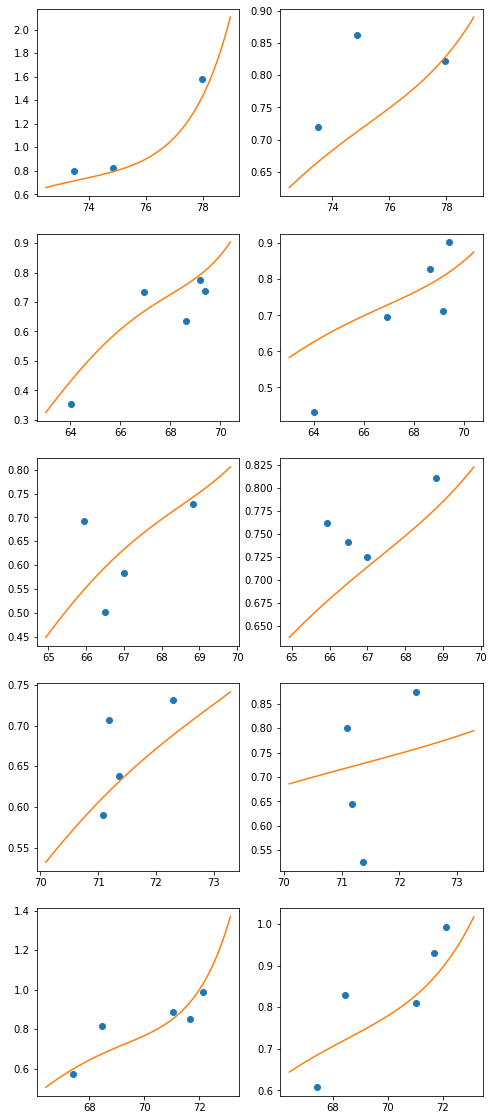

In [3]:
leaspy = Leaspy('linearB')
dimension = 2
sources_dimension = 1
leaspy.model.parameters = {'g': [0., 1.],
                           'v0':[.5, 0.],
                           'betas':[[1.]],
                           'tau_mean': 70., 'tau_std': 5.,
                           'xi_mean': 0., 'xi_std': .1,
                           'sources_mean': 0.,
                           'sources_std': 1.,
                           'noise_std': [.07]}
model1 = leaspy.model
leaspy.model.dimension = dimension
leaspy.model.source_dimension = sources_dimension
leaspy.model.parameters = {key: torch.tensor(val) for key, val in model1.parameters.items()}
leaspy.model.attributes = AttributesFactory.attributes(model1.name, dimension, sources_dimension)
leaspy.model.attributes._compute_positions(model1.parameters)
leaspy.model.attributes._compute_velocities(model1.parameters)
leaspy.model.attributes._compute_betas(model1.parameters)
leaspy.model.attributes._compute_orthonormal_basis()
leaspy.model.attributes._compute_mixing_matrix()
leaspy.model.is_initialized = True

print(leaspy.model.source_dimension)
model1=leaspy.model
periode = 15.
amplitude = 2.
model1.B = lambda x : torch.exp(torch.exp(0.1*x)-2)+torch.cos(x/5)*0.3

n_individuals = 500
nb_visits_min = 2
nb_visits_mean = 4
window = 2.

data, individuals = generate_data(model1, n_individuals, nb_visits_min, nb_visits_mean, window)

leaspy_data = Data.from_dataframe(data)

nb_ind_plot = 5

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(dimension * 4, nb_ind_plot * 4))

plot_generative(ax, individuals, model1, nb_ind_plot, dimension)
plt.show()

over-fitting avec un grand nombre de points dec ontrole

In [9]:
os.chdir("/Users/samuel.gruffaz/Documents/data")
df = pd.read_csv("AILZ_no_filtre.csv", dtype={'ID':str})
df.set_index(['ID','TIME'], inplace=True)
os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

leaspy_data=Data.from_dataframe(df)

 [-8.88617283e-04 -1.40856958e-03 -6.59487458e-03  5.31508253e-03
   4.53476697e-03  9.95420873e-03 -1.14771029e-04 -8.32478268e-03]
 [-7.13492737e-04 -5.31129271e-04 -1.32185510e-03  1.31083714e-03
   1.17060543e-03  2.00799937e-03 -1.10466625e-04 -2.11893319e-03]
 [ 5.48294099e-03  3.25276151e-03 -1.14745503e-03  3.98197529e-03
  -4.34487493e-03  7.70893216e-03 -4.40725653e-04 -6.60024266e-03]
 [ 4.49540468e-03  1.38674703e-03  2.80360931e-04  1.81014514e-03
  -4.91528181e-04  1.55434293e-03  2.50109503e-04 -1.78035282e-03]
 [-3.45267831e-03 -1.58730893e-03 -3.29587947e-04 -2.82169581e-03
   1.43732951e-03 -4.57169067e-03  1.34409485e-04  2.98926994e-03]
 [ 2.07272924e-03  1.86492447e-03 -2.88346182e-04 -1.29910537e-03
  -4.00116500e-03  6.86141767e-04 -1.63699490e-04 -1.62546450e-03]
 [ 7.38810884e-04  2.47188661e-03  1.90754062e-03 -3.01006291e-04
  -3.89393036e-03  1.64687943e-03 -1.43495989e-04  3.40535000e-03]
 [ 1.59513280e-02  7.70723250e-03 -4.42063729e-03 -8.82811019e-03
  -

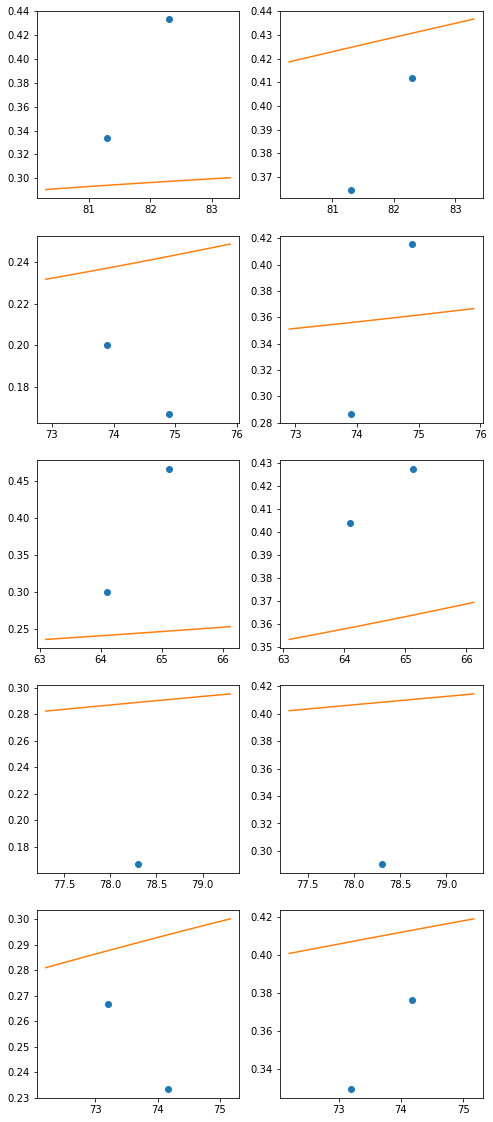

In [12]:
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 0.2,
               "nb_compose":4,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE",progress_bar=True)

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
plt.show()

In [ ]:
print(leaspy.model.name)

In [ ]:
#500 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 40,"nb_compose":4,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/test500varinewsig.json')   
plt.show()

In [ ]:
#500 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/test500vari.json')   
plt.show()

In [ ]:

os.chdir("/Users/samuel.gruffaz/leaspype_kernel/leaspy")
leaspy_test.save('example/start/outputs/logs/test500vari.json')   

In [ ]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True, 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
#500 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/test500.json')   
plt.show()

In [ ]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True, 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/test500.json') 
plt.show()

In [ ]:
#100 patients
leaspy_test = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True,
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1500, loss="MSE_diag_noise",progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
leaspy_test.save('example/start/outputs/logs/test.json')   
plt.show()

In [ ]:
os.chdir("/Users/samuel.gruffaz/documents/PEcollab")
leaspy_test=leaspy.load('example/start/outputs/logs/test.json')

In [13]:
from leaspy.utils.visualisation.visual_update_b import *

4
norme W
tensor([0.0326, 0.0222, 0.0357, 0.0195, 0.0369, 0.0364, 0.0053, 0.0415])
norme W
tensor([0.0359, 0.0268, 0.0276, 0.0242, 0.0422, 0.0398, 0.0067, 0.0437])
norme W
tensor([0.0326, 0.0259, 0.0315, 0.0227, 0.0451, 0.0369, 0.0060, 0.0412])
norme W
tensor([0.0297, 0.0415, 0.0275, 0.0164, 0.0515, 0.0303, 0.0062, 0.0477])
ipykernel_launcher:9: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


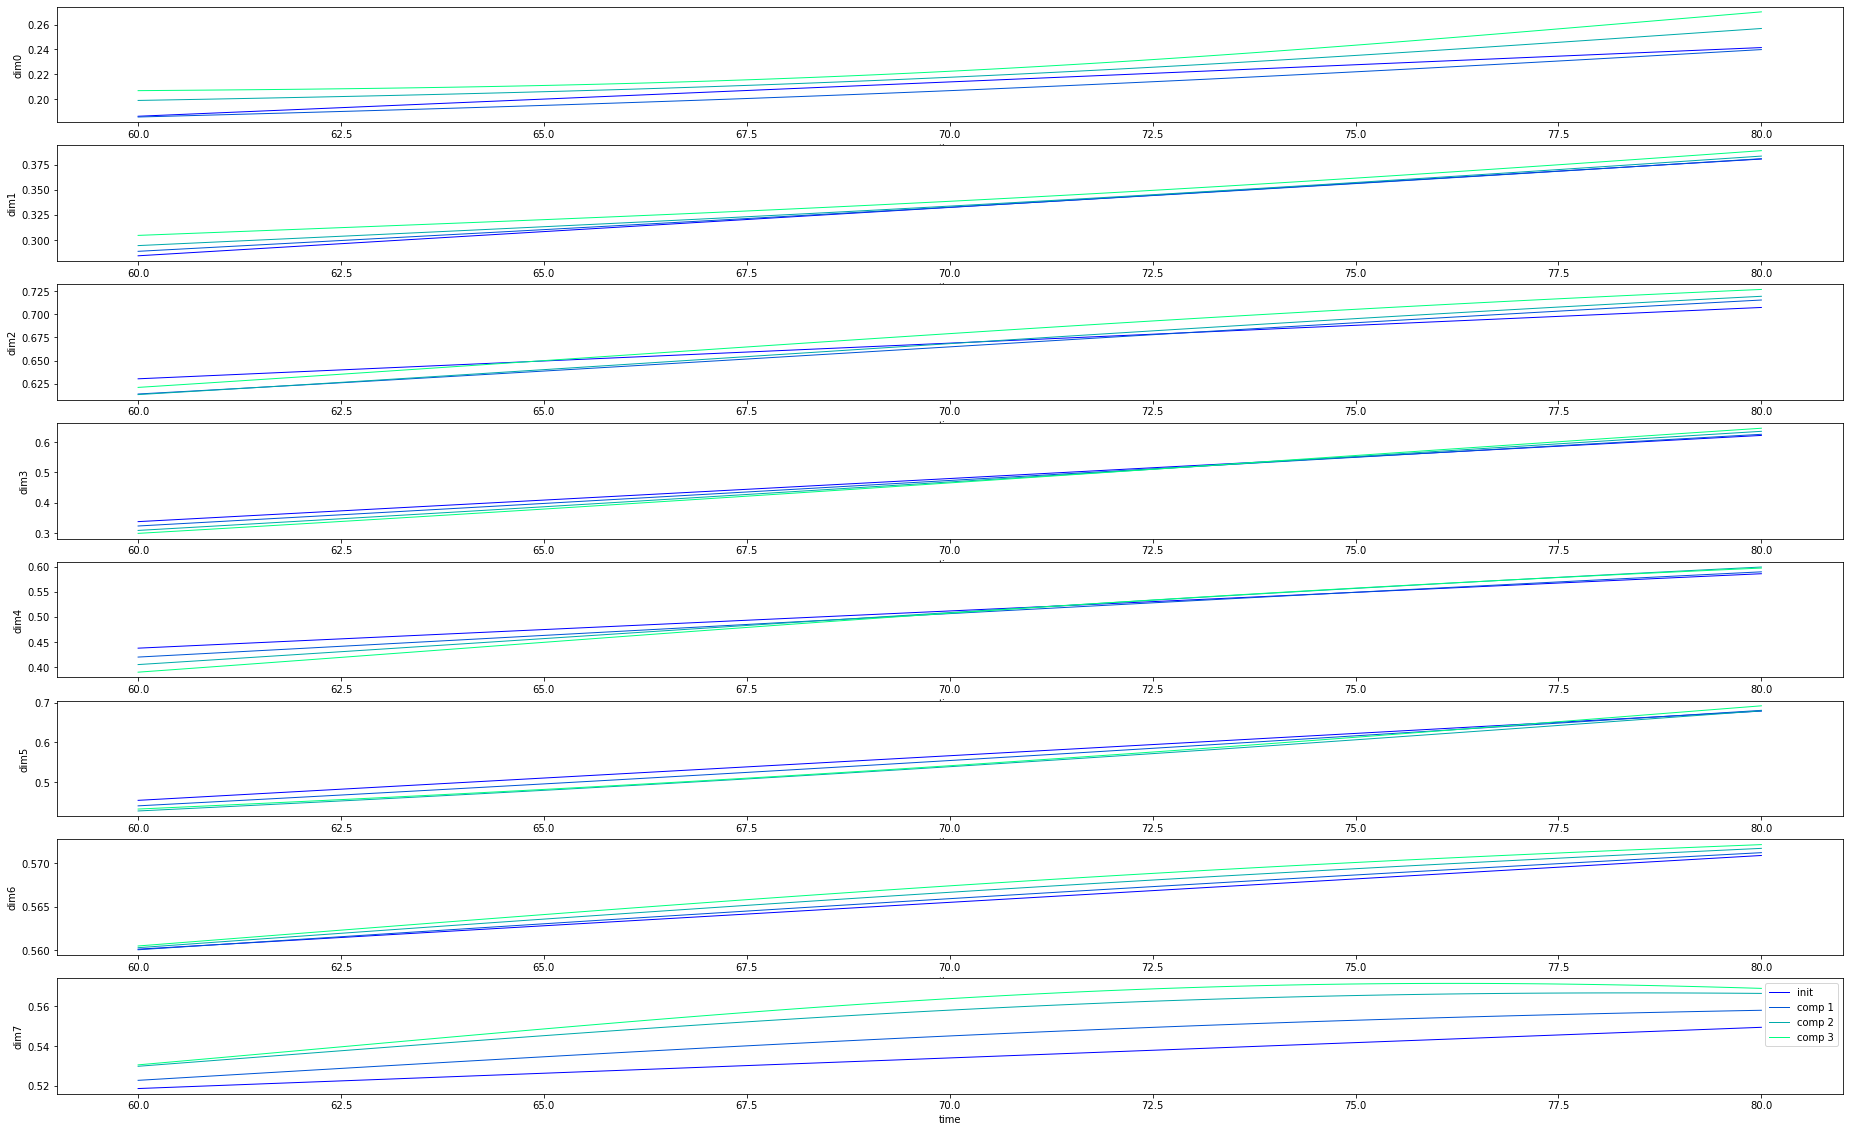

In [17]:
dimension=8
nb_ind_plot=5
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))

#plot_average_update(leaspy_test,ax,leaspy,"référence")
plot_average_update(leaspy_test,ax)

plt.legend()
fig.show()

In [ ]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma_auto" : True, 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
a=1
list(a)

In [ ]:
tps=torch.linspace(65,80,100)
nb_vari=20
fen=5
plot_variability(leaspy_test,tps,nb_vari,fen)

In [ ]:
def plot_average_update(model,ax,modelref=None):
    """
    Parameters: model, linear_b model already calibrated with update_b
        ax, (dimension) subplots

    """
    timepoints = np.linspace(60, 80, 100)
    if modelref is not None:
        number_of_sources = modelref.model.random_variable_informations()["sources"]["shape"][0]
        mean_xiref = modelref.model.parameters['xi_mean'].numpy()
        mean_tauref = modelref.model.parameters['tau_mean'].numpy()
        mean_sourceref = modelref.model.parameters['sources_mean'].numpy().tolist()
        mean_sourcesref = [mean_sourceref]*number_of_sources
        average_parametersref = {'xi': mean_xiref,'tau': mean_tauref,'sources': mean_sourcesref}
        ip_averageref = IndividualParameters()
        ip_averageref.add_individual_parameters('average', average_parametersref)
        valuesref = model.estimate({'average': timepoints}, ip_averageref)
        for i in range(d):
            ax[i].plot(timepoints, valuesref['average'].T[i], linewidth=3,label=modelref.name)


    # —— Get the average individual parameters
    d=model.model.dimension
    
    Lparam=model.model.saveParam
    LB=model.model.saveB.copy()
    print(len(LB))
    for i in range(d):
        
        number_of_sources = model.model.random_variable_informations()["sources"]["shape"][0]
        for j in range(len(LB)):
            
            mean_xi = Lparam[j]['xi_mean'].numpy()
            mean_tau = Lparam[j]['tau_mean'].numpy()
            mean_source = Lparam[j]['sources_mean'].numpy().tolist()
            mean_sources = [mean_source]*number_of_sources
            model.model.saveB=LB[:j]
            model.model.reconstructionB()

# —— Store the average individual parameters in a dedicated object
            average_parameters = {'xi': mean_xi,'tau': mean_tau,'sources': mean_sources}
            ip_average = IndividualParameters()
            ip_average.add_individual_parameters('average', average_parameters)
            values = model.estimate({'average': timepoints}, ip_average)
            
            ax[i].plot(timepoints, values['average'].T[i], linewidth=3,label="comp "+str(j))
        ax[i].set_xlabel("time")
        ax[i].set_ylabel("dim"+str(i))
        
    model.model.saveB=LB

In [ ]:
def plot_variability(model, tps,nb_vari,fen):
    params={}
    

    nb_s=model.model.source_dimension
    print(nb_s)
    dimension=model.model.dimension
    fig1, ax1 = plt.subplots(dimension, nb_s, figsize=(4*dimension,16*nb_s))
    for i in range(nb_s):
        SS=torch.zeros(nb_vari,nb_s)
        SS[:,i]=torch.linspace(-fen,fen,nb_vari)
        
        t = tps

        
        for j in range(dimension):
            for k in range(nb_vari):
        
                mean_par={"tau":model.model.parameters["tau_mean"],"xi":model.model.parameters["xi_mean"]}
                mean_par["sources"] = SS[k]
                trajectory = model.model.compute_individual_tensorized(t, mean_par).squeeze(0)
                
                if len(ax1.shape)>1:
                    ax1[j,i].plot(t, trajectory[..., j],label="source "+str(i)+": {:.2f}".format(SS[k,i]))
                else:
                    ax1[j].plot(t, trajectory[..., j],label="source "+str(i)+": {:.2f}".format(SS[k,i]))
    plt.legend()
    plt.show()

In [ ]:

fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

In [ ]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test,ax)
plt.legend()
fig.show()

In [ ]:
leaspy_test1 = Leaspy('linearB')
nb_ind_plot=5
dimension=2
leaspy_test1.model.load_hyperparameters({'source_dimension': 1}) # Optional
dataset = Dataset(leaspy_data)

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 0.4, 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'init_b':'identity'}

algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test1.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test1.model, dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test1,ax)
plt.legend()
fig.show()

si sigma est trop grand on arrive pas à s'adapter sans faire de la merde

choix de sigma automatisé en prenant la médiane des distances interpoints ?

In [ ]:
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 5,"nb_compose":5,"nb_compose_succ":1,'iter_in_fit':200,'iter_out_fit':300,'iter_begin_fit':100,'init_real':results}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss='MSE',progress_bar=True)
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test1.fit_B(leaspy_data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model, dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
tps=torch.linspace(65,80,100)
nb_vari=5
fen=2
plot_variability(leaspy_test,tps,nb_vari,fen)

In [ ]:
fig, ax = plt.subplots( dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_average_update(leaspy_test1,ax)
plt.legend()
fig.show()

In [ ]:
data = Data.from_csv_file(os.path.join('example','start','inputs', 'data_normalized.csv'))
dataset = Dataset(data)

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dimension=4

logi=lambda: x: 1./(1.+torch.exp(-x))
meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'init_b':"logistic"}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
#plot_generative(ax, individuals, model1, nb_ind_plot, dimension)


results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
os.chdir("/Users/samuel.gruffaz/Documents/PEcollab")

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 1}) # Optional
dimension=4

logi=lambda x: 1./(1.+torch.exp(-x))

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)



In [ ]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

In [ ]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=4

logi=lambda x: 1./(1.+torch.exp(-x))

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":4,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

In [ ]:
fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

In [ ]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [ ]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]
dg=df[df.columns[3:6]]
data = Data.from_dataframe(dg)
dataset=Dataset(data)

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

In [ ]:
nb_ind_plot=5
dimension=3

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

In [ ]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [ ]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]
dg=df[df.columns[3:6]]*3
data = Data.from_dataframe(dg)
dataset=Dataset(data)

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 1., 
                 "nb_control_points" : 10,"nb_compose":1,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

In [ ]:
nb_ind_plot=5
dimension=3

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

In [ ]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 1)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600']
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()
    
plot_trajectory(timepoints, values['average'])

In [ ]:
os.chdir("/Users/samuel.gruffaz/Documents/data/")
df=pd.read_csv("ADNI_img_clean.csv")
df = df.set_index(['ID', 'TIME'])
indices = [idx for idx in df.index.unique('ID') if df.loc[idx].shape[0] >= 2]
df = df[df.index.get_level_values(0).isin(indices)]
dg=df[df.columns[43:49]]*3
data = Data.from_dataframe(dg)
dataset=Dataset(data)



In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 3., 
                 "nb_control_points" : 10,"nb_compose":1,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

In [ ]:
nb_ind_plot=5
dimension=6

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)

In [ ]:
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 3)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600',"blue","yellow"]
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()

plot_trajectory(timepoints, values['average'])

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 2}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 3., 
                 "nb_control_points" : 10,"nb_compose":1,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

In [ ]:
nb_ind_plot=5
dimension=6

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 3)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600',"blue","yellow"]
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()

plot_trajectory(timepoints, values['average'])

In [ ]:
leaspy_test = Leaspy('linearB')

leaspy_test.model.load_hyperparameters({'source_dimension': 4}) # Optional
dimension=3

logi=lambda x:-x

meta_settings = {"kernel_name" : "gaussian", 
                 "sigma" : 2., 
                 "nb_control_points" : 10,"nb_compose":2,'B_init':logi}
algo_settings = AlgorithmSettings('mcmc_saem', n_iter=1000, loss="MSE_diag_noise")
perso_settings = AlgorithmSettings('scipy_minimize', use_jacobian=False, loss="MSE")



results=leaspy_test.fit_B(data,algo_settings,perso_settings,meta_settings)

In [ ]:
nb_ind_plot=5
dimension=6

fig, ax = plt.subplots(nb_ind_plot, dimension, figsize=(4*dimension,4*nb_ind_plot))
plot_points(ax, dataset, nb_ind_plot, dimension)
plot_fit(ax, results, leaspy_test.model,dataset, nb_ind_plot, dimension)
    
plt.show()

In [ ]:
# —— Get the average individual parameters
mean_xi = leaspy_test.model.parameters['xi_mean'].numpy()
mean_tau = leaspy_test.model.parameters['tau_mean'].numpy()
mean_source = leaspy_test.model.parameters['sources_mean'].numpy().tolist()
number_of_sources = leaspy_test.model.source_dimension
mean_sources = [mean_source]*number_of_sources

# —— Store the average individual parameters in a dedicated object
average_parameters = {
    'xi': mean_xi,
    'tau': mean_tau,
    'sources': mean_sources
}

ip_average = IndividualParameters()
ip_average.add_individual_parameters('average', average_parameters)
timepoints = np.linspace(50, 100, 100)
values = leaspy_test.estimate({'average': timepoints}, ip_average)
def plot_trajectory(timepoints, reconstruction, observations=None):

    if observations is not None:
        ages = observations.index.values
    
    plt.figure(figsize=(10, 5))
    plt.ylim(0, 3)
    colors = ['#003f5c', '#7a5195', '#ef5675', '#ffa600',"blue","yellow"]
    
    for c, name, val in zip(colors, leaspy_test.model.features, reconstruction.T):
        plt.plot(timepoints, val, label=name, c=c, linewidth=3)
        if observations is not None:
            plt.plot(ages, observations[name], c=c, marker='o', markersize=12, 
                     linewidth=1, linestyle=':')
    
    plt.xlim(min(timepoints), max(timepoints))
    plt.grid()
    plt.legend()
    plt.show()

plot_trajectory(timepoints, values['average'])